In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,roc_curve

In [2]:
#Reading Data
train = pd.read_csv('data/titanicTrain.csv')
#Adding an index
# train = train.reset_index()
train.shape

(8693, 14)

In [3]:
#Kind of Data
train.dtypes.value_counts()

object     7
float64    6
bool       1
dtype: int64

In [4]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

## Handling Missing Values

In [5]:
train.isna().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

In [6]:
train.isnull().sum(axis=1).sort_values(ascending=False).head(2087)
#Max number of null values per row is 3, 2087 rows with atleast one value

3882    3
7211    3
2639    3
4164    3
7682    3
       ..
4347    1
7       1
8687    1
1307    1
23      1
Length: 2087, dtype: int64

In [7]:
#For Sure, WE don't know missing names or cabins and can safely assume that if VIP is null, it is most likely False.
train[train.Name.isna()]
train.Name.fillna('X',inplace=True)

train[train.Cabin.isna()]
train.Cabin.fillna('X/00/X',inplace=True)

train[train.VIP.isna()]
train.VIP.fillna('False',inplace=True)


In [8]:
#Imputing the numeric data type null values using the median value for that colum. (Age, Food Court, Room Service, Shopping Mall, VR Deck, Spa)
n_cols = train.select_dtypes(exclude=['object','bool','int64']).columns
for i in n_cols:
    train[i].fillna(train[i].median(),inplace=True)

In [9]:
train.isna().sum().sort_values(ascending=False).head(10)

CryoSleep       217
HomePlanet      201
Destination     182
PassengerId       0
Cabin             0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
dtype: int64

In [10]:
train.isnull().sum(axis=1).sort_values(ascending=False).head(1074)
#1073 rows have atleast one null value. Maximum null values per row is 3

3622    2
5687    2
6629    2
347     2
7218    2
       ..
6222    0
6184    0
6185    0
6186    0
6211    0
Length: 1074, dtype: int64

In [11]:
train.loc[:,train.columns.isin(['CryoSleep','Destination','HomePlanet','VIP'])] = train.loc[:,train.columns.isin(['CryoSleep','Destination','HomePlanet','VIP'])].astype(str).apply(LabelEncoder().fit_transform)

In [12]:
train.CryoSleep.value_counts()

0    5439
1    3037
2     217
Name: CryoSleep, dtype: int64

In [13]:
train.HomePlanet = train.HomePlanet.apply(lambda x : np.nan if x==3 else x)
train.Destination = train.Destination.apply(lambda x : np.nan if x==3 else x)
train.CryoSleep = train.CryoSleep.apply(lambda x : np.nan if x==2 else x)

In [14]:
train.loc[:,train.columns.isin(['CryoSleep','Destination','HomePlanet','VIP'])]

,HomePlanet,CryoSleep,Destination,VIP
0,1.0,0.0,2.0,0
1,0.0,0.0,2.0,0
2,1.0,0.0,2.0,1
3,1.0,0.0,2.0,0
4,0.0,0.0,2.0,0
...,...,...,...,...
8688,1.0,0.0,0.0,1
8689,0.0,1.0,1.0,0
8690,0.0,0.0,2.0,0
8691,1.0,0.0,0.0,0


In [15]:
train.isna().sum().sort_values(ascending=False).head(10)

CryoSleep       217
HomePlanet      201
Destination     182
PassengerId       0
Cabin             0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
dtype: int64

In [16]:
y = train.Transported
train.drop('Transported',axis=1,inplace=True)

In [17]:
#All columns that still have null values. (CryoSleep, HomePlanet, Destination,Age, Food Court, Room Service, Shopping Mall, VR Deck, Spa), We impute using KNNImputer

imputer = KNNImputer(n_neighbors=1,weights='uniform',metric='nan_euclidean')
train_transform = imputer.fit_transform(train.loc[:,~train.columns.isin(['Name','Cabin','PassengerId','index'])])

In [18]:
train_transform = pd.DataFrame(train_transform,columns=['HomePlanet', 'CryoSleep','Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck'])
train_transform[['Name','Cabin','PassengerId']] = train[['Name','Cabin','PassengerId']]

In [19]:
train_transform.isna().sum().sort_values(ascending=False)

#NO NULL VALUES

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Cabin           0
PassengerId     0
dtype: int64

## Visualizing the Data

<AxesSubplot:xlabel='Transported', ylabel='count'>

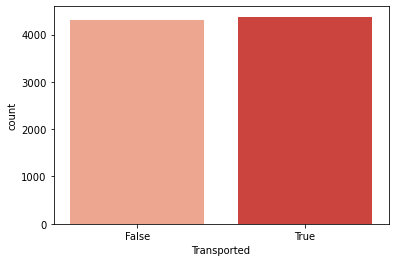

In [20]:
sns.countplot(x=y,palette='Reds')
#Quite well balanced

In [21]:
train_transform.PassengerId.nunique()

8693

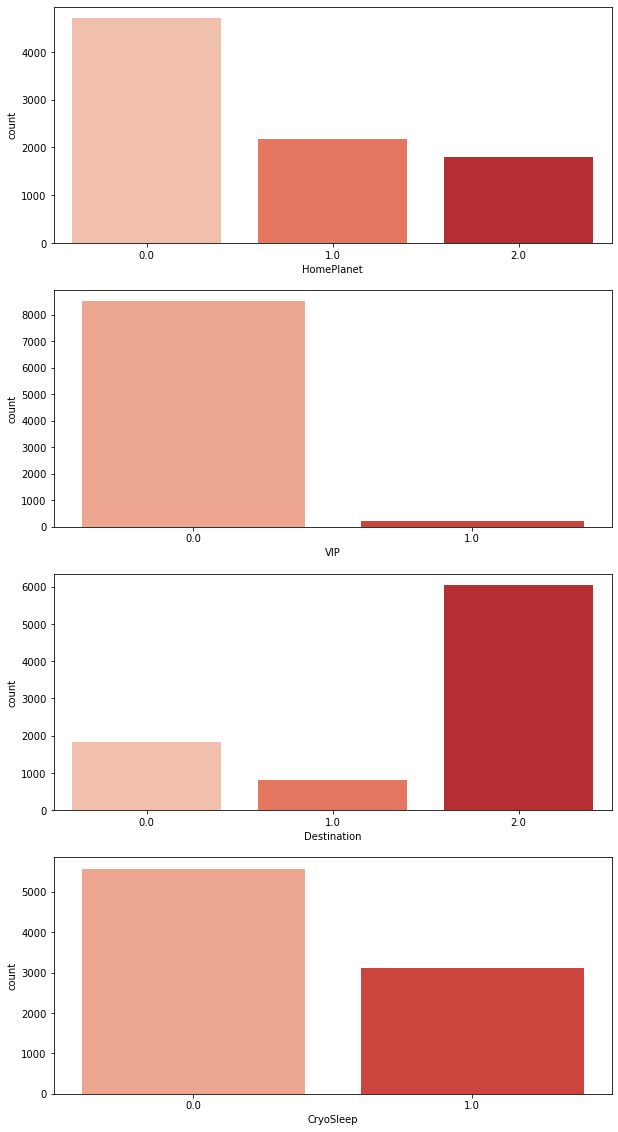

In [22]:
cols = ['HomePlanet','VIP','Destination','CryoSleep']
fig,ax = plt.subplots(len(cols),1,figsize=(10,20))
for i in cols:
    sns.countplot(x=i,data=train_transform,palette='Reds',ax=ax[cols.index(i)])

In [23]:
train_transform.Name.value_counts().head(20)
#20 names repeat twice

X                     200
Alraium Disivering      2
Apix Wala               2
Asch Stradick           2
Sus Coolez              2
Glenna Valezaley        2
Carry Contrevins        2
Gwendy Sykess           2
Sharie Gallenry         2
Elaney Webstephrey      2
Cuses Pread             2
Glena Hahnstonsen       2
Dia Cartez              2
Loree Wolfernan         2
Gollux Reedall          2
Juane Popelazquez       2
Troya Schwardson        2
Keitha Josey            2
Grake Porki             2
Anton Woody             2
Name: Name, dtype: int64

In [24]:
train_transform[['HomePlanet','CryoSleep','Destination','VIP']] = train_transform[['HomePlanet','CryoSleep','Destination','VIP']].astype(object)

In [25]:
f_cols = train_transform.select_dtypes(include=['float64']).columns
for i in f_cols:
    print(f'{i} : {train_transform[i].nunique()} ')

Age : 80 
RoomService : 1273 
FoodCourt : 1507 
ShoppingMall : 1115 
Spa : 1327 
VRDeck : 1306 


In [26]:
train_transform['Group_id'] = train_transform['PassengerId'].apply(lambda x : x.split('_')[0])
train_transform['p_id'] = train_transform['PassengerId'].apply(lambda x : x.split('_')[1])

In [27]:
dict_id = train_transform.p_id.value_counts()
dict_id

01    6217
02    1412
03     571
04     231
05     128
06      75
07      46
08      13
Name: p_id, dtype: int64

In [28]:
n_p =[]
for i in dict_id.keys():
    s=dict_id.values.sum()
    val=dict_id[i]
    s = s-sum(n_p)-val
    n_p.append(s)
n_p.append(dict_id[i])
n_p.remove(2476)
dict_p = {i+1:n_p[i] for i in range(8)}

Text(0, 0.5, 'Number of Groups')

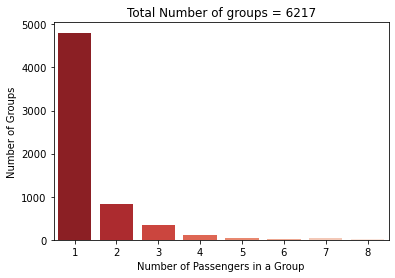

In [29]:
red_palette = sns.color_palette('Reds',n_colors=8)
red_palette.reverse()
sns.barplot(x=list(dict_p.keys()),y=list(dict_p.values()),palette=red_palette)
plt.title(f'Total Number of groups = {train_transform.Group_id.nunique()}')
plt.xlabel("Number of Passengers in a Group")
plt.ylabel("Number of Groups")

In [30]:
train_transform[['Deck','Num','Side']]=train_transform.Cabin.str.split('/',expand=True)

<AxesSubplot:xlabel='Deck', ylabel='count'>

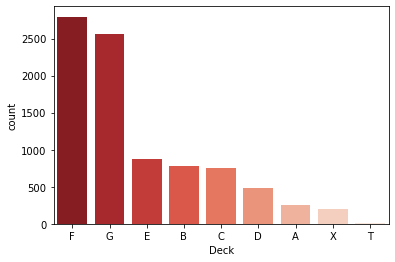

In [31]:
red_palette = sns.color_palette('Reds',n_colors=9)
red_palette.reverse()
sns.countplot(x='Deck',data=train_transform,palette=red_palette,order=train_transform.Deck.value_counts().index)

In [32]:
train_transform.Num.nunique()

1818

<AxesSubplot:xlabel='Side', ylabel='count'>

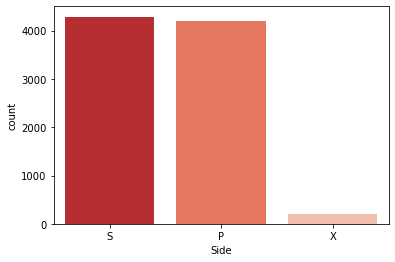

In [33]:
red_palette = sns.color_palette('Reds',n_colors=3)
red_palette.reverse()
sns.countplot(x='Side',data=train_transform,palette=red_palette,order=train_transform.Side.value_counts().index)

In [34]:
#labelencode side and deck

In [35]:
train_transform.drop(['PassengerId','Cabin'],axis=1,inplace=True)

In [36]:
train_transform.loc[:,train_transform.columns.isin(['Deck','Side'])] = train_transform.loc[:,train_transform.columns.isin(['Deck','Side'])].astype(str).apply(LabelEncoder().fit_transform)
train_transform

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group_id,p_id,Deck,Num,Side
0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0001,01,1,0,0
1,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,0002,01,5,0,1
2,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0003,01,0,0,1
3,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0003,02,0,0,1
4,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,0004,01,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1.0,0.0,0.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,9276,01,0,98,0
8689,0.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,9278,01,6,1499,1
8690,0.0,0.0,2.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,9279,01,6,1500,1
8691,1.0,0.0,0.0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,9280,01,4,608,1


In [37]:
train_transform[['Deck','Side']]=train_transform[['Deck','Side']].astype(object)

In [38]:
train_transform.dtypes.value_counts()

object     10
float64     6
dtype: int64

In [39]:
labelEnc = LabelEncoder()
y = labelEnc.fit_transform(y)

## Classification Models

In [40]:
x_train, x_test, y_train, y_test = train_test_split(train_transform, y, test_size=0.2,random_state=0)

In [41]:
x_train = x_train.loc[:,x_train.columns!='Name']
x_test = x_test.loc[:,x_test.columns!='Name']

x_train = x_train.astype(float)
x_test = x_test.astype(float)

x_train.corr(method='pearson')

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_id,p_id,Deck,Num,Side
HomePlanet,1.000000,0.079374,0.037422,0.140927,0.125821,0.217089,0.066554,0.099722,0.055666,0.038120,-0.004101,0.039651,-0.386277,-0.196615,0.005148
CryoSleep,0.079374,1.000000,-0.101665,-0.072676,-0.080016,-0.248247,-0.211106,-0.207195,-0.203088,-0.195660,-0.002146,0.052797,0.022150,-0.036487,0.028876
Destination,0.037422,-0.101665,1.000000,-0.004657,-0.042813,0.044137,-0.105450,0.026264,-0.050663,-0.067998,0.000378,-0.031149,0.171320,0.104579,-0.021840
Age,0.140927,-0.072676,-0.004657,1.000000,0.092948,0.064585,0.127748,0.031091,0.114059,0.100377,-0.003612,-0.145653,-0.228655,-0.123583,0.015478
VIP,0.125821,-0.080016,-0.042813,0.092948,1.000000,0.055938,0.115719,0.023596,0.069037,0.132765,0.020809,0.007387,-0.165289,-0.092901,-0.011187
RoomService,0.217089,-0.248247,0.044137,0.064585,0.055938,1.000000,-0.010378,0.043190,0.015674,-0.015917,0.000173,-0.015620,-0.018289,-0.019116,-0.002910
FoodCourt,0.066554,-0.211106,-0.105450,0.127748,0.115719,-0.010378,1.000000,-0.014406,0.205244,0.215896,-0.014956,0.024089,-0.299695,-0.177961,0.027727
ShoppingMall,0.099722,-0.207195,0.026264,0.031091,0.023596,0.043190,-0.014406,1.000000,0.019299,-0.012883,0.021650,-0.039906,-0.036063,0.005285,-0.020911
Spa,0.055666,-0.203088,-0.050663,0.114059,0.069037,0.015674,0.205244,0.019299,1.000000,0.152706,0.000132,0.021013,-0.204199,-0.126372,0.014283
VRDeck,0.038120,-0.195660,-0.067998,0.100377,0.132765,-0.015917,0.215896,-0.012883,0.152706,1.000000,0.020697,0.002292,-0.239211,-0.131841,0.000393


# Logistic Regression


In [42]:
logit_model = sm.Logit(y_train,x_train.astype(float))
logit_result = logit_model.fit()
logit_result.summary() 

Optimization terminated successfully.
         Current function value: 0.448280
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6954
Model:                          Logit   Df Residuals:                     6939
Method:                           MLE   Df Model:                           14
Date:                Fri, 17 Jun 2022   Pseudo R-squ.:                  0.3532
Time:                        04:24:15   Log-Likelihood:                -3117.3
converged:                       True   LL-Null:                       -4820.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
HomePlanet       0.3480      0.045      7.761      0.000       0.260       0.436
CryoSleep        1.6844      0.079     21.347      0.000       1.530       1.839
Destination     -0.1409      0.040     -3.529      0.000      -0.219      -0.063
Age             -0.0022      0.002     -1.048      0.295      -0.006       0.002
VIP             -0.3440      0.253     -1.358      0.175      -0.841       0.153
RoomService     -0.0015      0.000    -14.459      0.000      -0.002      -0.001
FoodCourt        0.0007    4.5e-05     15.222      0.000       0.001       0.001
ShoppingMall     0.0006   7.11e-05      8.898      0.000       0.000       0.001
Spa             -0.0017      0.000    -15.045      0.000      -0.002      -0.001
VRDeck          -0.0015      0.000    -14.713      0.000      -0.002      -0.001
Group_id      4.392e-05   1.82e-05      2.417      0.016    8.31e-06    7.95e-05
p_id             0.1220      0.029      4.165      0.000       0.065       0.179
Deck            -0.1932      0.019     -9.961      0.000      -0.231      -0.155
Num              0.0001      0.000      1.183      0.237   -8.41e-05       0.000
Side             0.6075      0.061      9.979      0.000       0.488       0.727
================================================================================
"""

In [43]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(x_train, y_train)
logreg_y = logreg.predict(x_test)

In [44]:
def classification_metrics(x_test,y_test,y_pred,model):
    print(f'Accuracy : {model.score(x_test,y_test)}\n\n')
    cfm = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred)+'\n\n')
    fig,ax = plt.subplots(1,2,figsize=(18,6))

    sns.heatmap(cfm,annot=True,fmt='g',cmap='Reds',ax=ax[0])
    ax[0].set_title("Confusion Matrix")

    logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    ax[1].plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    ax[1].plot([0, 1], [0, 1],'r--')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver operating characteristic')
    ax[1].legend(loc="lower right")


Accuracy : 0.7849338700402531


              precision    recall  f1-score   support

           0       0.79      0.77      0.78       863
           1       0.78      0.80      0.79       876

    accuracy                           0.78      1739
   macro avg       0.79      0.78      0.78      1739
weighted avg       0.79      0.78      0.78      1739





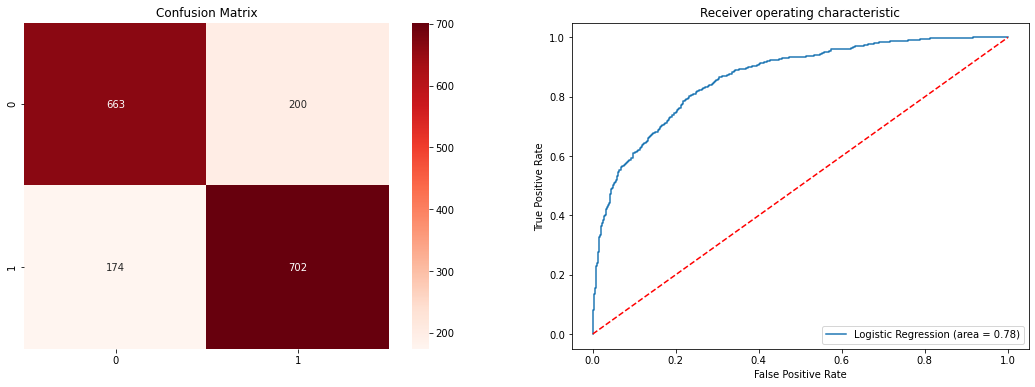

In [45]:
classification_metrics(x_test,y_test,logreg_y,logreg)

# Linear Discriminant Analysis

In [46]:
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(x_train,y_train)
lda_y =lda_model.predict(x_test)

Accuracy : 0.7567567567567568


              precision    recall  f1-score   support

           0       0.73      0.82      0.77       863
           1       0.80      0.70      0.74       876

    accuracy                           0.76      1739
   macro avg       0.76      0.76      0.76      1739
weighted avg       0.76      0.76      0.76      1739





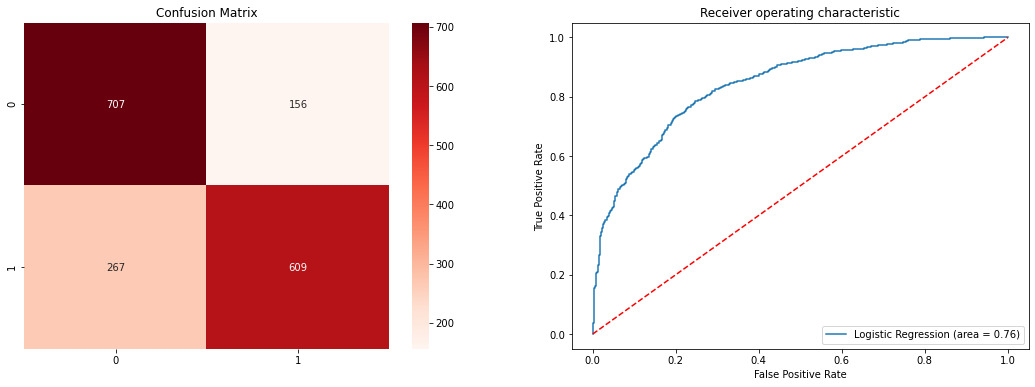

In [47]:
classification_metrics(x_test,y_test,lda_y,lda_model)

# Quadratic Discriminant Analysis

In [48]:
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(x_train,y_train)
qda_y =qda_model.predict(x_test)

Accuracy : 0.7027027027027027


              precision    recall  f1-score   support

           0       0.86      0.48      0.62       863
           1       0.64      0.92      0.76       876

    accuracy                           0.70      1739
   macro avg       0.75      0.70      0.69      1739
weighted avg       0.75      0.70      0.69      1739





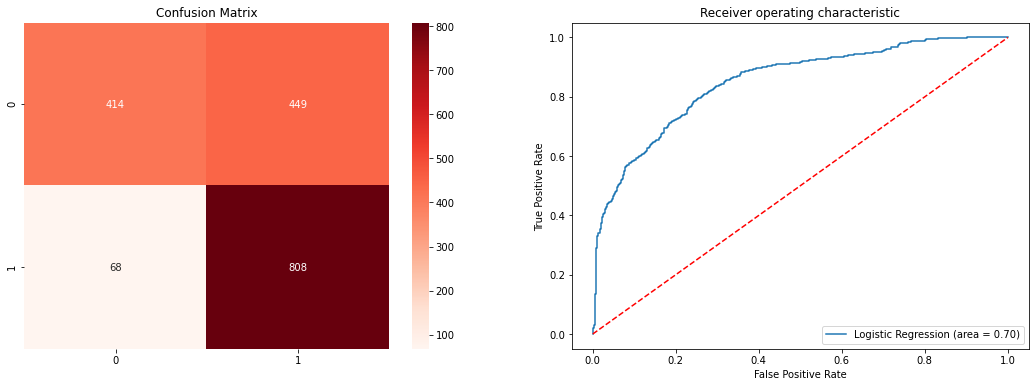

In [49]:
classification_metrics(x_test,y_test,qda_y,qda_model)

# Decision Tree

In [50]:
desc_tree = DecisionTreeClassifier(random_state=0)
desc_tree_model = desc_tree.fit(x_train,y_train)
desc_tree_y = desc_tree_model.predict(x_test)

Accuracy : 0.7475560667050029


              precision    recall  f1-score   support

           0       0.76      0.72      0.74       863
           1       0.74      0.77      0.76       876

    accuracy                           0.75      1739
   macro avg       0.75      0.75      0.75      1739
weighted avg       0.75      0.75      0.75      1739





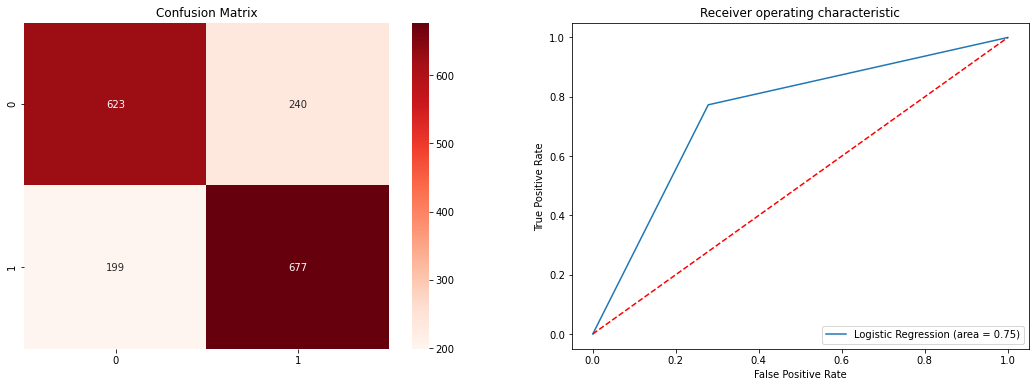

In [51]:
classification_metrics(x_test,y_test,desc_tree_y,desc_tree_model)

# Random Forest

In [52]:
n = len(x_train.columns)

In [53]:
rf = RandomForestClassifier(random_state=0,oob_score=True,bootstrap=True,n_estimators=500,max_features='sqrt')
rf_model = rf.fit(x_train,y_train)
rf_y = rf_model.predict(x_test)

Accuracy : 0.8056354226566993


              precision    recall  f1-score   support

           0       0.79      0.83      0.81       863
           1       0.82      0.78      0.80       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739





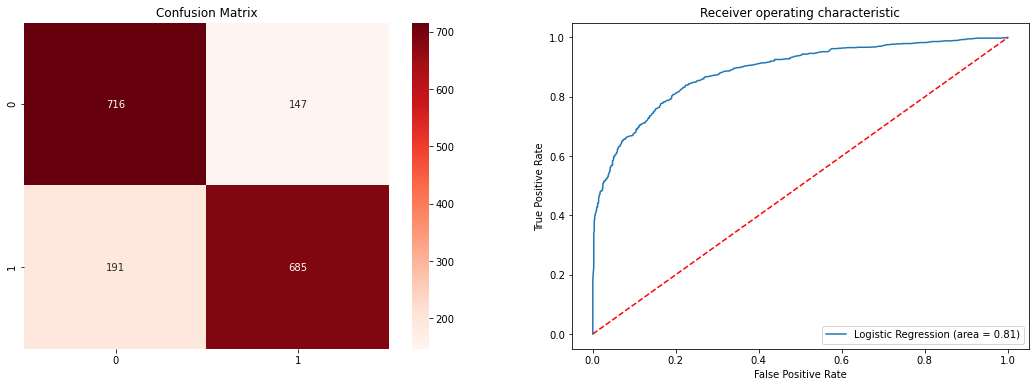

In [54]:
classification_metrics(x_test,y_test,rf_y,rf_model)

# Bagging

In [55]:
bg = BaggingClassifier(base_estimator=desc_tree,random_state=0)
bg_model = bg.fit(x_train,y_train)
bg_y = bg_model.predict(x_test)

Accuracy : 0.7947096032202415


              precision    recall  f1-score   support

           0       0.77      0.84      0.80       863
           1       0.83      0.75      0.79       876

    accuracy                           0.79      1739
   macro avg       0.80      0.80      0.79      1739
weighted avg       0.80      0.79      0.79      1739





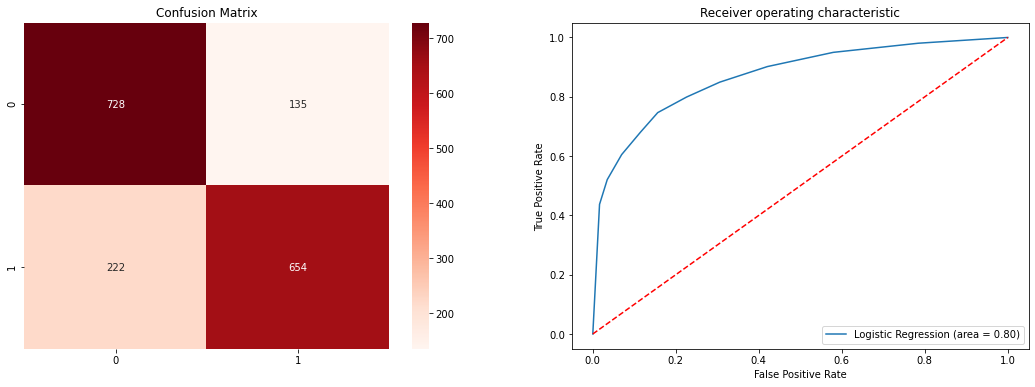

In [56]:
classification_metrics(x_test,y_test,bg_y,bg_model)

# KNN

In [57]:
knn = KNeighborsClassifier(n_neighbors=3)
knn_model = knn.fit(x_train,y_train)
knn_y = knn_model.predict(x_test)

Accuracy : 0.7481311098332375


              precision    recall  f1-score   support

           0       0.75      0.74      0.74       863
           1       0.75      0.76      0.75       876

    accuracy                           0.75      1739
   macro avg       0.75      0.75      0.75      1739
weighted avg       0.75      0.75      0.75      1739





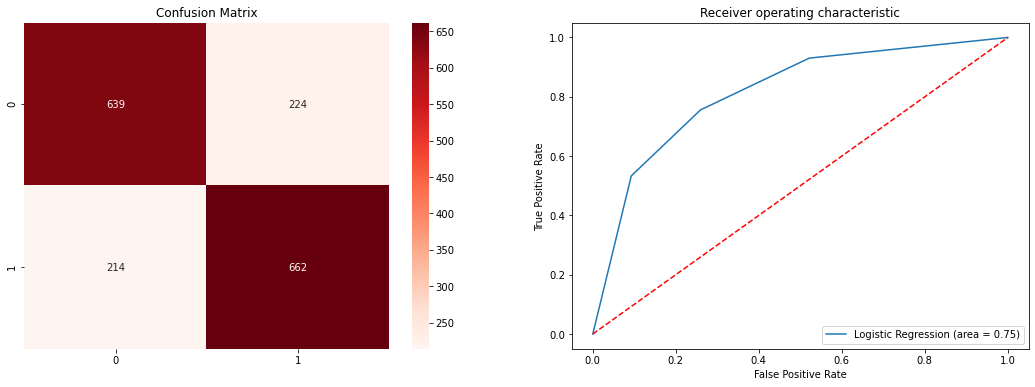

In [58]:
classification_metrics(x_test,y_test,knn_y,knn_model)

In [59]:
#SCALE
# svc = SVC(kernel='linear')
# svc_model = svc.fit(x_train, y_train)
# svc_y = svc_model.predict(x_test)
# classification_metrics(x_test,y_test,svc_y,svc_model)

In [60]:
svc = SVC(kernel='rbf',probability=True)
svc_model = svc.fit(x_train, y_train)
svc_y = svc_model.predict(x_test)

Accuracy : 0.7717078780908568


              precision    recall  f1-score   support

           0       0.86      0.64      0.74       863
           1       0.72      0.90      0.80       876

    accuracy                           0.77      1739
   macro avg       0.79      0.77      0.77      1739
weighted avg       0.79      0.77      0.77      1739





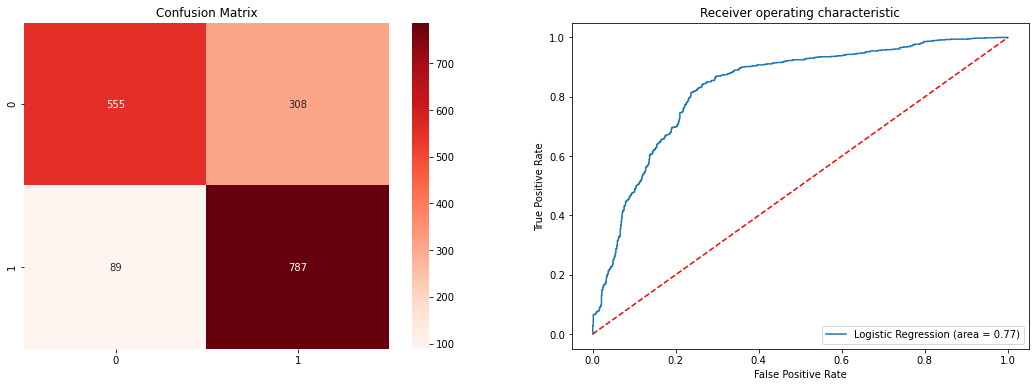

In [61]:
classification_metrics(x_test,y_test,svc_y,svc_model)

In [62]:
svc = SVC(kernel='poly',probability=True)
svc_model = svc.fit(x_train, y_train)
svc_y = svc_model.predict(x_test)

Accuracy : 0.6871765382403681


              precision    recall  f1-score   support

           0       0.88      0.43      0.58       863
           1       0.63      0.94      0.75       876

    accuracy                           0.69      1739
   macro avg       0.75      0.69      0.66      1739
weighted avg       0.75      0.69      0.66      1739





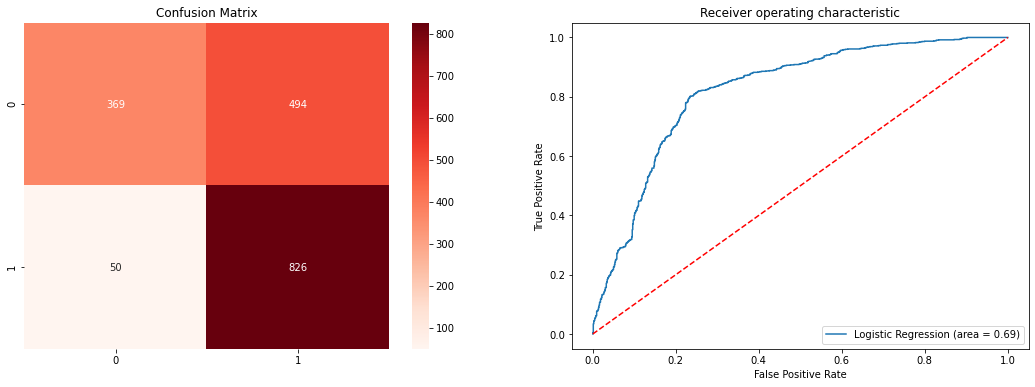

In [63]:
classification_metrics(x_test,y_test,svc_y,svc_model)

# Boosting

Accuracy : 0.7935595169637722


              precision    recall  f1-score   support

           0       0.81      0.76      0.78       863
           1       0.78      0.83      0.80       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739





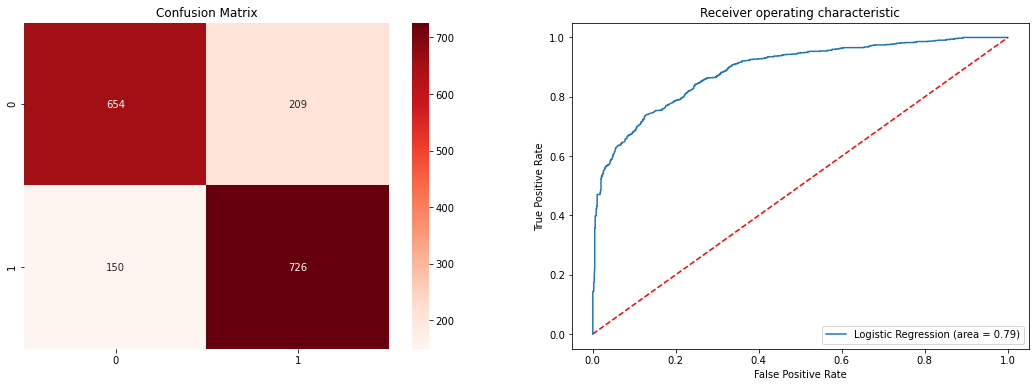

In [64]:
boost = GradientBoostingClassifier()
boost_model=boost.fit(x_train,y_train)
boost_y = boost_model.predict(x_test)
classification_metrics(x_test,y_test,boost_y,boost_model)